## Advanced Lane Finding Project
-----------------------------------------------------------------------------------------------
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def find_ChessboardCorners_from_images(images):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    return objpoints, imgpoints


# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

#  find ChessboardCorners
objpoints, imgpoints = find_ChessboardCorners_from_images(images)

### 2nd, I'll get distortion parameter with Chessbord Corners points. Apply a distortion correction to raw images.

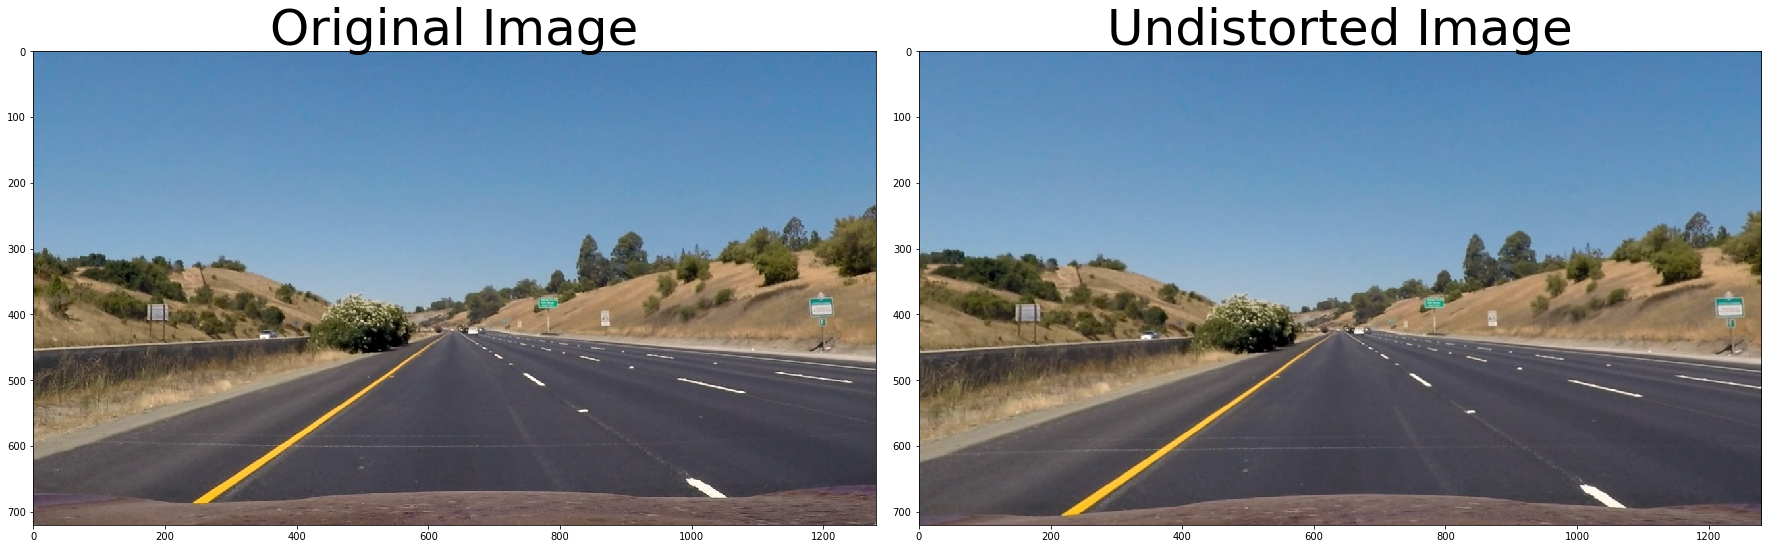

In [2]:
# takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    return undist

# Read in an image
#img = cv2.imread('camera_cal/calibration2.jpg')
img = mpimg.imread('test_images/straight_lines1.jpg') 
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 3rd. use color transforms, gradients, etc., to create a thresholded binary image.

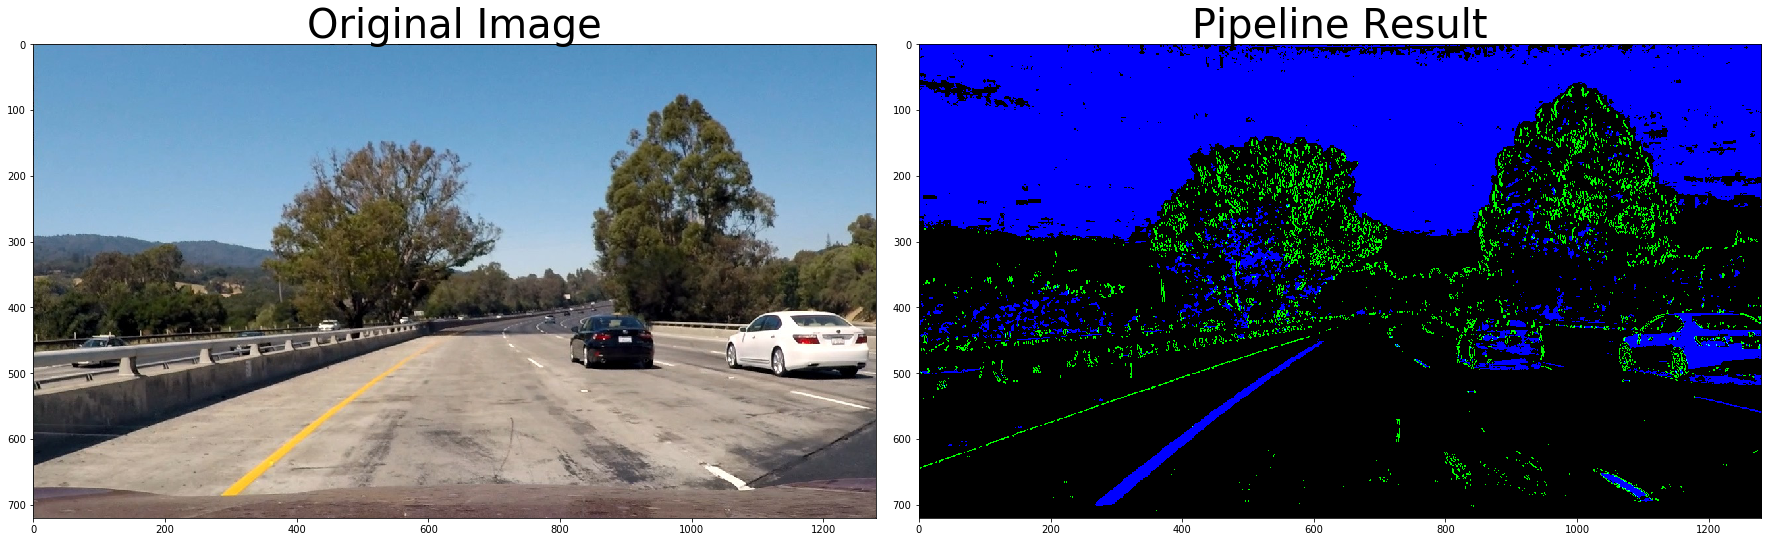

In [76]:
# Read in an image, you can also try test1.jpg or test4.jpg
image = mpimg.imread('test_images/test1.jpg') 
#image = mpimg.imread('test_images/straight_lines1.jpg') 

#def use_color_filters(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
def use_color_filters(img, s_thresh=(120, 255), sx_thresh=(30, 80)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

undistorted = cal_undistort(image, objpoints, imgpoints)
result = use_color_filters(undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4th. Apply a perspective transform to rectify binary image ("birds-eye view").

In [77]:
def warped(img, width = 0.16, height = 0.6):
    # Define the vertices of a triangular mask.
    # This time we are defining a four sided polygon to mask
    imshape    = img.shape
    img_size = (img.shape[1], img.shape[0])
    #print(img_size)
    apex_c     = [int(imshape[1]/2), int(imshape[0]*height)]
    apex_w     = int(imshape[1]*width)
    apex_bx    = int(imshape[1]*0.0)
    apex_by    = int(imshape[0]*0.0)
    src        = np.float32([[apex_bx,imshape[0]-apex_by],
                            [apex_c[0]-apex_w/2, apex_c[1]], 
                            [apex_c[0]+apex_w/2, apex_c[1]],
                            [imshape[1]-apex_bx,imshape[0]-apex_by]])
    dst        = np.float32([[0,imshape[0]],
                            [0, 0], 
                            [imshape[1],0],
                            [imshape[1],imshape[0]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

def inv_warped(img, width = 0.16, height = 0.6):
    # Define the vertices of a triangular mask.
    # This time we are defining a four sided polygon to mask
    imshape    = img.shape
    img_size = (img.shape[1], img.shape[0])
    #print(img_size)
    apex_c     = [int(imshape[1]/2), int(imshape[0]*height)]
    apex_w     = int(imshape[1]*width)
    apex_bx    = int(imshape[1]*0.0)
    apex_by    = int(imshape[0]*0.0)
    src        = np.float32([[apex_bx,imshape[0]-apex_by],
                            [apex_c[0]-apex_w/2, apex_c[1]], 
                            [apex_c[0]+apex_w/2, apex_c[1]],
                            [imshape[1]-apex_bx,imshape[0]-apex_by]])
    dst        = np.float32([[0,imshape[0]],
                            [0, 0], 
                            [imshape[1],0],
                            [imshape[1],imshape[0]]])
    
    M = cv2.getPerspectiveTransform(dst, src)
    iwarped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return iwarped


"""
warped_image = warped(result)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped_image)
ax2.set_title('Warped Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
"""

"\nwarped_image = warped(result)\n\n# Plot the result\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\n\nax1.imshow(image)\nax1.set_title('Original Image', fontsize=40)\n\nax2.imshow(warped_image)\nax2.set_title('Warped Result', fontsize=40)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n"

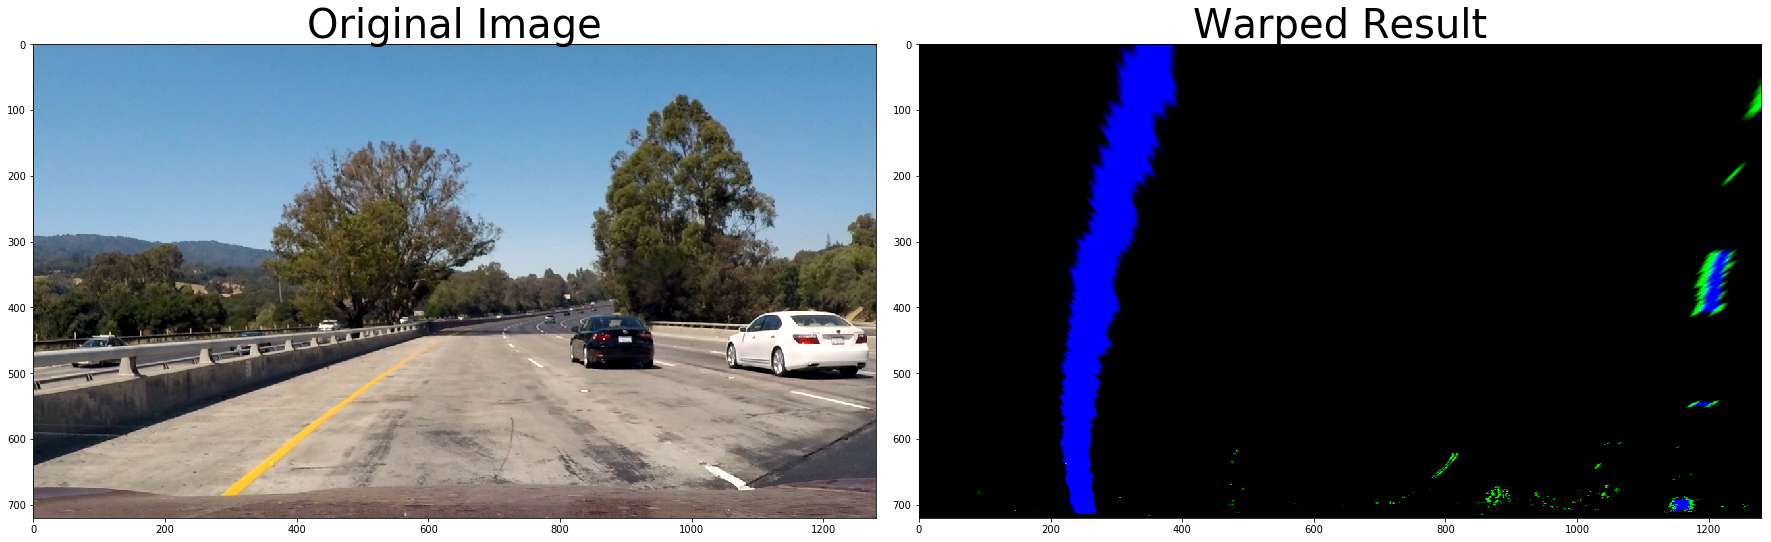

In [73]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    bottom_half = gray[gray.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

"""
# Create histogram of image binary activations
hist_value = 0
w_ref = 0
h_ref = 0
for h in range(600, 700, 1):
    print(h)
    for w in range(0,1000,1):
        warped_image = warped(result, w*0.001, h*0.001)
        histogram = hist(warped_image)
        max_h  = histogram.max()
        mean_h = histogram.mean()
        if max_h > hist_value:
            hist_value = max_h
            w_ref    = w*0.001
            h_ref    = h*0.001

            # Visualize the resulting histogram
            plt.plot(histogram)
print(w_ref, h_ref)
warped_image = warped(result, w_ref, h_ref)
"""
#warped_image = warped(result, 0.129, 0.638)  # test_images/straight_lines1.jpg 
#warped_image = warped(result, 0.111, 0.628)  # test_images/straight_lines2.jpg
warped_image = warped(result, 0.12, 0.633)  # average

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped_image)
ax2.set_title('Warped Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 5th. Detect lane pixels and fit to find the lane boundary.

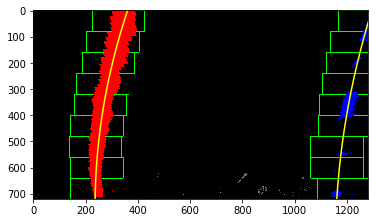

In [78]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin
        win_xleft_high = leftx_current+margin
        win_xright_low = rightx_current-margin
        win_xright_high = rightx_current+margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
     
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit


def visualize_fit_polynominal(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

#binary_warped = cv2.threshold(warped_image,64,255,cv2.THRESH_BINARY)
binary_warped = cv2.cvtColor(warped_image, cv2.COLOR_RGB2GRAY)
out_img = visualize_fit_polynominal(binary_warped)

plt.imshow(out_img)

In [13]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fitx, right_fitx, ploty, left_fit, right_fit

def find_lane_pixels_around_poly(binary_warped, left_fit, right_fit, margin = 80):
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    center_left  = left_fit[0]*nonzeroy**2  + left_fit[1]*nonzeroy  + left_fit[2]
    center_right = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]
    left_lane_inds = ( (nonzerox >= (center_left - margin)) & 
                       (nonzerox <= (center_left + margin)) ).nonzero()[0]
    right_lane_inds = ( (nonzerox >= (center_right - margin)) & 
                       (nonzerox <= (center_right + margin)) ).nonzero()[0]

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

previous: [-2.71199796e-05  1.51466859e-02  2.12425014e+02]
update: [ 8.91145617e-05 -1.58495212e-01  3.06048468e+02]


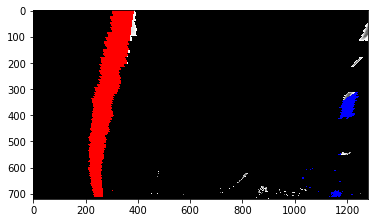

In [79]:
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 80

    # extract left and right line pixel positions
    leftx, lefty, rightx, righty =  find_lane_pixels_around_poly(binary_warped, left_fit, right_fit, margin)

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    center_left  = left_fit[0]*nonzeroy**2  + left_fit[1]*nonzeroy  + left_fit[2]
    center_right = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]
    left_lane_inds = ( (nonzerox >= (center_left - margin)) & 
                       (nonzerox <= (center_left + margin)) ).nonzero()[0]
    right_lane_inds = ( (nonzerox >= (center_right - margin)) & 
                       (nonzerox <= (center_right + margin)) ).nonzero()[0]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return ploty, left_fit, right_fit, out_img

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
print('previous:', left_fit)
ploty, left_fit, right_fit, detected_lane_img = search_around_poly(binary_warped, left_fit, right_fit)
print('update:', left_fit)
plt.imshow(detected_lane_img)

## 6th. Determine the curvature of the lane and vehicle position with respect to center.

In [15]:
def measure_curvature_real(leftx, lefty, rightx, righty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    ##### Fit new polynomials to x,y in world space #####
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value(to cover same y-range as image), corresponding to the bottom of the image
    y_eval = 719*ym_per_pix

    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**(3/2)/(np.abs(2* left_fit_cr[0]))
    right_curverad = (1+(2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**(3/2)/(np.abs(2* right_fit_cr[0]))
    
    
    ##### vehicle position is estimated with center of the lane marker #####
    vehicle_position = (left_fit_cr[2] + right_fit_cr[2])/2 - (1280*xm_per_pix/2)
    
    return left_curverad, right_curverad, vehicle_position


# Calculate the radius of curvature in meters for both lane lines
# HYPERPARAMETER: Choose the width of the margin around the sliding window polynomial to search
margin = 80
leftx, lefty, rightx, righty =  find_lane_pixels_around_poly(binary_warped, left_fit, right_fit, margin)
left_curverad, right_curverad, vehicle_position = measure_curvature_real(leftx, lefty, rightx, righty)

print(left_curverad, 'm', right_curverad, 'm', vehicle_position, 'm')

377.55693668912215 m 278.10469466130877 m -0.6434029258416265 m


## 7th. Warp the detected lane boundaries back onto the original image.



In [18]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

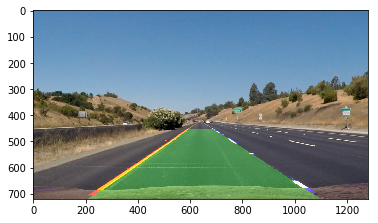

In [44]:
def draw_detected_lane_boundaries(detected_lane_img, left_fit, right_fit):
    # Grab activated pixels
    nonzero = detected_lane_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    center_left  = left_fit[0]*nonzeroy**2  + left_fit[1]*nonzeroy  + left_fit[2]
    center_right = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]
    left_lane_inds = ( (nonzerox >= (center_left - margin)) & 
                       (nonzerox <= (center_left + margin)) ).nonzero()[0]
    right_lane_inds = ( (nonzerox >= (center_right - margin)) & 
                       (nonzerox <= (center_right + margin)) ).nonzero()[0]
    
    # Create an image to draw on and an image to show the selection window
    lane_img = detected_lane_img
    img_shape = lane_img.shape

    # Color in left and right line pixels
    lane_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    lane_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_pts = np.hstack((left_line, right_line))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(lane_img, np.int_([lane_pts]), (0, 50, 0))
    result = cv2.addWeighted(detected_lane_img, 1, lane_img, 0.8, 0)
    inv_warped_image = inv_warped(result, 0.12, 0.633)  # average

    return inv_warped_image

inv_warped_image = draw_detected_lane_boundaries(detected_lane_img, left_fit, right_fit)
lane_boundaries_img = weighted_img(inv_warped_image, image, 1.0, 0.8, 0)
plt.imshow(lane_boundaries_img)

## 8th. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

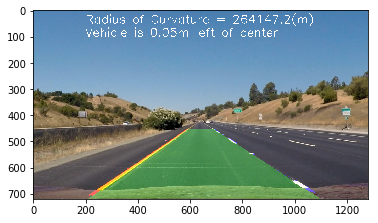

In [45]:
def put_estimated_lane_curvature_and_vehicle_position(img, curvature, position):
    radius_text = 'Radius of Curvature = ' + "{0:.1f}".format(curvature)+'(m)'
    pos_text    = 'Vehicle is '+ "{0:.2f}".format(position)+'m left of center'
    
    cv2.putText(img, radius_text, (200, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), thickness=2)
    cv2.putText(img, pos_text, (200, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), thickness=2)

    return img

lane_boundaries_img = weighted_img(inv_warped_image, image, 1.0, 0.8, 0)
out_img = put_estimated_lane_curvature_and_vehicle_position(lane_boundaries_img, (left_curverad + right_curverad)/2, vehicle_position)
plt.imshow(out_img)

## 9th. pipeline function to proceed with all test image.

['test6.jpg', 'test5.jpg', 'test4.jpg', 'test1.jpg', 'test3.jpg', 'test2.jpg', 'straight_lines2.jpg', 'straight_lines1.jpg']


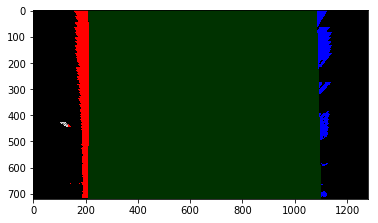

In [53]:
import os

def process_image(image):
    # use color transforms, gradients, etc., to create a thresholded binary image.
    undistorted = cal_undistort(image, objpoints, imgpoints)
    binary_img = use_color_filters(undistorted)
    
    # Apply a perspective transform to rectify binary image ("birds-eye view").
    warped_image = warped(binary_img, 0.12, 0.633) 
    
    # Detect lane pixels and fit to find the lane boundary.
    binary_warped = cv2.cvtColor(warped_image, cv2.COLOR_RGB2GRAY)
    left_fit, right_fit = fit_polynomial(binary_warped)
    ploty, left_fit, right_fit, detected_lane_img = search_around_poly(binary_warped, left_fit, right_fit)

    # Determine the curvature of the lane and vehicle position with respect to center.
    margin = 100
    leftx, lefty, rightx, righty =  find_lane_pixels_around_poly(binary_warped, left_fit, right_fit, margin)
    left_curverad, right_curverad, vehicle_position = measure_curvature_real(leftx, lefty, rightx, righty)

    # Warp the detected lane boundaries back onto the original image
    inv_warped_image = draw_detected_lane_boundaries(detected_lane_img, left_fit, right_fit)
    lane_boundaries_img = weighted_img(inv_warped_image, image, 1.0, 0.8, 0)

    # Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    lane_boundaries_img = weighted_img(inv_warped_image, image, 1.0, 0.8, 0)
    out_img = put_estimated_lane_curvature_and_vehicle_position(lane_boundaries_img, (left_curverad + right_curverad)/2, vehicle_position)

    return detected_lane_img

# Read in the image
files= os.listdir("test_images/")
print(files)

for filename in files:
    # read file
    image = mpimg.imread('test_images/' + filename)
    out_img = process_image(image)
    plt.imshow(out_img)

    mpimg.imsave('output_images/' + filename, out_img)

In [54]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output_images/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [08:03<00:00,  2.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 14min 2s, sys: 1min 33s, total: 15min 35s
Wall time: 8min 3s


In [55]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))